# <center>Projet Topic Modeling</center>

During the Natural Language Processing course, text representation algorithms have been introduced. However they don't suffice to the creation of complete NLP systems.

Most of them usually rely on text pre-processing at first -- in other words, they rely on a specific data pipeline that is tied to the final task you are trying to solve.

As a result, we will try in this notebook to create a pipeline from scratch given a specific final task.

# Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import nltk

import itertools
import itertools
import os
import re
import secrets
import string
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style

import pandas as pd
import spacy

from itertools import chain
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet
# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
import gensim.corpora as corpora

from spacy.parts_of_speech import IDS as POS_map

You can load the dataset using pandas and the [.read_json()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html) method. Try loading your dataset here:

In [2]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})

------

A good way to get the grasp of your corpus is to count the occurences of words across it. For convenience, we've defined a dummy function that splits words by checking where spaces are and... Simply that. This is the most basic form of word identification in text that could be used.

In [3]:
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.
        
        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words
            
        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))
        
    return texts_out

In [4]:
splitted_texts = dummy_word_split(dataset["headline"].tolist())

In [5]:
splitted_texts[0] + splitted_texts[1]

['There',
 'Were',
 '2',
 'Mass',
 'Shootings',
 'In',
 'Texas',
 'Last',
 'Week,',
 'But',
 'Only',
 '1',
 'On',
 'TV',
 'Will',
 'Smith',
 'Joins',
 'Diplo',
 'And',
 'Nicky',
 'Jam',
 'For',
 'The',
 '2018',
 'World',
 "Cup's",
 'Official',
 'Song']

Now, let's define a function that counts word occurences and highlight what are the most important words of our corpus:

In [6]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """
    
    words = itertools.chain.from_iterable(texts)
    
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

Once this is done, display the top 20 most occuring words in your texts.

In [7]:
compute_word_occurences(splitted_texts).head(1000)

,Word,Count
0,The,47803
1,To,38569
2,A,24839
3,In,24141
4,Of,22956
...,...,...
995,Father's,258
996,Netflix,258
997,Park,258
998,Culture,257


Does it make sense, and can you leverage such results?

# Actual pipeline

As you have seen above, the results obtained from a simple word count aren't so great. Similar words doesn't add up (such as run and running), and you have a lot of noise included. Words such as *the*, *you*, *an* could be removed for instance.

Actually, a lot can be done. Let's check that out.

----------

## What does the pipeline look like?

A NLP data pipeline often relies on the following elements. Some can be added, some can be removed, but they all look like this at some point:

1. **Ensuring data quality.** You have to make sure that there's no N/A in your data and that everything is in the good format shape. Having this as the entrance of your pipeline will save you a lot of time in the long run, so try defining it thoroughly.


2. **Filtering texts from unwanted characters**. Especially if you get data from web, you'll end up with HTML tags or encoding stuff that you don't need in your texts. Before applying anything to them, you need to get them cleaned up. Here, try removing the dates and the punctuation for instance.


3. **Unify your texts**. (*This is topic modeling specific*). You don't want to make the difference between a word at the beginning of a phrase of in the middle of it here. You should unify all your words by lowercasing them and deaccenting them as well.


4. **Converting sentences to lists of words**. Some words aren't needed for our analyses, such as *your*, *my*, etc. In order to remove them easily, you have to convert your sentences to lists of words. You can use the dummy function defined above but I'd advised against it. Try finding a function that does that smoothly in [gensim.utils](https://radimrehurek.com/gensim/utils.html)!


5. **Remove useless words**. You need to remove useless words from your corpus. You have two approaches: [use a hard defined list of stopwords](https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/) or rely on TF-IDF to identify useless words. The first is the simplest, the second might yield better results!


6. **Creating n-grams**. If you look at New York, it is composed of two words. As a result, a word count wouldn't really return a true count for *New York* per se. In NLP, we represent New York as New_York, which is considered a single word. The n-gram creation consists in identifying words that occur together often and regrouping them. It boosts interpretability for topic modeling in this case.


7. **Stemming / Lemmatization**. Shouldn't run, running, runnable be grouped and counted as a single word when we're identifying discussion topics? Yes, they should. Stemming is the process of cutting words to their word root (run- for instance) quite brutally while lemmatization will do the same by identifying the kind of word it is working on. You should convert the corpus words into those truncated representations to have a more realistic word count.


8. **Part of speech tagging**. POS helps in the identification of verbs, nouns, adjectives, etc. For topic models, it is a good idea to work only on verbs and nouns. Adjectives don't convey info about the actual underlying topic discussed at hand.

## Let's create it!

Now it's your turn. Try to implement each step of the pipeline, and compare the word counts obtained earlier and the one obtained after preprocessing your texts.

### Ensuring data quality

In [8]:
def check_data_quality(texts):
    """Check wheter all the dataset is conform to the expected behaviour."""
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."
    
    return True

In [9]:
def force_format(texts):
    return [str(t) for t in texts]

In [10]:
texts = force_format(dataset["headline"])

In [11]:
print(f"Is the dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the dataset passing our data quality check?
True


### Filtering texts

https://regex101.com/

In [12]:
def filter_text(texts_in):
    """Removes incorrect patterns from a list of texts, such as hyperlinks, bullet points and so on"""
    
    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    # Mail regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r"(?i)(?:[a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out


In [13]:
texts = [filter_text(t) for t in texts]

### Unifying texts & converting sentences to list of words

In [14]:
def sent_to_words(sentences):
    """Converts sentences to words.

    Convert sentences in lists of words while removing the accents and the punctuation.

    @param:
        sentences: a list of strings, the sentences we want to convert
    @return
        A list of words' lists.
    """
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))


In [15]:
texts = list(sent_to_words(texts))

100%|███████████████████████████████████████████████████████████████████████| 200853/200853 [00:05<00:00, 34751.91it/s]


In [16]:
texts

[['there',
  'were',
  'mass',
  'shootings',
  'in',
  'texas',
  'last',
  'week',
  'but',
  'only',
  'on',
  'tv'],
 ['will',
  'smith',
  'joins',
  'diplo',
  'and',
  'nicky',
  'jam',
  'for',
  'the',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'for', 'the', 'first', 'time', 'at', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'and',
  'democrats',
  'in',
  'new',
  'artwork'],
 ['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'to',
  'pick',
  'up',
  'after',
  'her',
  'dog'],
 ['morgan',
  'freeman',
  'devastated',
  'that',
  'sexual',
  'harassment',
  'claims',
  'could',
  'undermine',
  'legacy'],
 ['donald',
  'trump',
  'is',
  'lovin',
  'new',
  'mcdonald',
  'jingle',
  'in',
  'tonight',
  'show',
  'bit'],
 ['what',
  'to',
  'watch',
  'on',
  'amazon',
  'prime',
  'that',
  'new',
  'this',
  'week'],
 ['mike',
  'myers',
  'reveals',
  'he',
  'like',
  'to',

## Remove useless words

In [17]:
en_stops = set(stopwords.words('english'))

## TF-IDF pour identifier les stopwords
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words=en_stops, ngram_range=(1,1))
tvec_weights = tvec.fit_transform(dataset['headline'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

## Liste pré-définis de stopwords à éliminer
for lists in texts:
    for word in en_stops:
        try:
            lists.remove(word)
        except Exception as e:
            e =""

### COMPTER LES MOTS A LA FIN DES DEUX METHODES ET LES COMPARER

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
texts

[['mass', 'shootings', 'texas', 'last', 'week', 'tv'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'first', 'time', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'democrats',
  'new',
  'artwork'],
 ['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'pick',
  'dog'],
 ['morgan',
  'freeman',
  'devastated',
  'sexual',
  'harassment',
  'claims',
  'could',
  'undermine',
  'legacy'],
 ['donald',
  'trump',
  'lovin',
  'new',
  'mcdonald',
  'jingle',
  'tonight',
  'show',
  'bit'],
 ['watch', 'amazon', 'prime', 'new', 'week'],
 ['mike', 'myers', 'reveals', 'like', 'fourth', 'austin', 'powers', 'film'],
 ['watch', 'hulu', 'new', 'week'],
 ['justin', 'timberlake', 'visits', 'texas', 'school', 'shooting', 'victims'],
 ['south',
  'korean',
  'president',
  'meets',
  'north',
  'korea',
  'kim',
  'jong',
  'un',
  'talk',
  'trump',
  'su

### Creating n-grams

In [19]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

def create_trigrams(texts, trigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify trigrams in texts and return the texts with trigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]


In [20]:
texts = create_bigrams(texts)

In [21]:
texts

['mass_shootings texas last week tv',
 'smith joins diplo nicky jam world_cup official song',
 'hugh grant marries first_time age',
 'jim_carrey blasts castrato adam schiff democrats new artwork',
 'julianna margulies uses donald_trump poop bags pick dog',
 'morgan_freeman devastated sexual_harassment claims could undermine legacy',
 'donald_trump lovin new mcdonald jingle tonight_show bit',
 'watch amazon prime new week',
 'mike myers reveals like fourth austin powers film',
 'watch hulu new week',
 'justin_timberlake visits texas school_shooting victims',
 'south_korean president meets north_korea kim_jong un talk trump summit',
 'way life risk remote oyster growing region called robots',
 'trump crackdown immigrant parents puts kids already strained system',
 'trump son concerned fbi obtained wiretaps putin ally met trump_jr',
 'edward_snowden one trump loves vladimir_putin',
 'booyah obama photographer hilariously trolls trump spy claim',
 'ireland votes repeal abortion amendment l

### Stemming / Lemmatization & Part-of-Speech filtering

In [22]:
def lemmatize_texts(texts, 
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], 
                    forbidden_postags=[], 
                    as_sentence=False, 
                    get_postags=False, 
                    spacy_model=None):
    """Lemmatize a list of texts.
    
            Please refer to https://spacy.io/api/annotation for details on the allowed
        POS tags.
        @params:
            - texts_in: a list of texts, where each texts is a string
            - allowed_postags: a list of part of speech tags, in the spacy fashion
            - as_sentence: a boolean indicating whether the output should be a list of sentences instead of a list of word lists
        @return:
            - A list of texts where each entry is a list of words list or a list of sentences
        """
    texts_out = []
    
    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]
        
    return texts_out

In [23]:
l_texts = lemmatize_texts(texts[:1000],
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'], 
                get_postags=False)

Loading spacy model
Beginning lemmatization process


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 541.75it/s]


## Latent Dirichlet Allocation

Nous allons utiliser LDA qui est un type de Machine Learning non supervisé (ce qu'on recherche dans notre cas).

L'objectif est de récupérer les paramètres des distributions dirichlet qui représentent la distribution des sujets dans les documents et la distribution des mots dans les sujets.

### LDA - Métrique de clustering

In [26]:
# Creation du dictionnaire 
id2word = corpora.Dictionary(l_texts)
# Creation du corpus
texts = l_texts
# Fréquence des termes du document
corpus = [id2word.doc2bow(text) for text in texts]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [27]:
# Construction du modèle LDA
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [29]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=l_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6235367897508647


Notre approche pour trouver le nombre optimal de sujets consiste à construire de nombreux modèles LDA avec différentes valeurs du nombre de sujets (k) et à choisir celui qui donne la valeur de cohérence la plus élevée.

Le choix d'un 'k' qui marque la fin d'une croissance rapide de la cohérence des sujets offre généralement des sujets significatifs et interprétables. Le choix d'une valeur encore plus élevée peut parfois fournir des sous-thèmes plus granulaires.

Si vous voyez les mêmes mots-clés répétés dans plusieurs sujets, c'est probablement un signe que le 'k' est trop grand.
La fonction compute_coherence_values() (voir ci-dessous) entraîne plusieurs modèles LDA et fournit les modèles et leurs scores de cohérence correspondants.

#### Cohérence score

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=l_texts, start=2, limit=40, step=6)

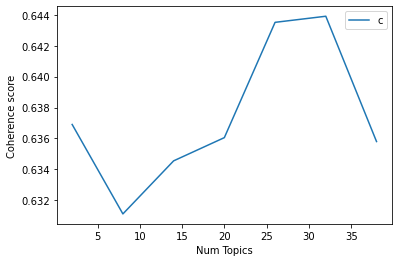

In [38]:
# Affichage du graphe

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Affichage des scores de cohérence
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6369
Num Topics = 8  has Coherence Value of 0.6311
Num Topics = 14  has Coherence Value of 0.6346
Num Topics = 20  has Coherence Value of 0.6361
Num Topics = 26  has Coherence Value of 0.6435
Num Topics = 32  has Coherence Value of 0.6439
Num Topics = 38  has Coherence Value of 0.6358


On voit qu'à partir de 32 topics, la cohérence diminue donc on peut considérer que pour ce modèle, 32 topics est l'idéal.

### LDA - Visualisation des données

In [42]:
# Passage d'une liste de liste de mot à une liste de string
# Cela permettra de transformer notre corpus 
str1 = ""
for text in l_texts:
    str1 += " ".join(text)
    str1 += " /£$/ " 
l_texts = str1.split(" /£$/ ")

vectorized_texts = l_texts
vect = CountVectorizer(stop_words='english')
vect_text = vect.fit_transform(vectorized_texts)
print(vect_text.shape)

(1001, 3077)


In [43]:
# Tweak the two parameters below
number_topics = 32
number_words = 8

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, learning_decay=0.9)
lda.fit(vect_text)


import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = pyLDAvis.sklearn.prepare(lda, vect_text, vect, mds='tsne')
lda_viz

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Logiciels\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances'

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
26     155.151199   36.278305       1        1  4.730703
5     -131.914932   -3.397024       2        1  4.378364
0       31.717001 -133.396774       3        1  4.178791
3      -32.374249   -4.346441       4        1  4.109581
18     -24.857260 -139.877930       5        1  4.054920
10     -15.525512   82.146507       6        1  4.045864
25       3.262083  132.633148       7        1  3.872080
14      89.945427 -123.698547       8        1  3.701833
22      33.162086   84.514923       9        1  3.585314
12     115.785126   74.316360      10        1  3.453014
27    -103.795822  -57.195789      11        1  3.414926
15    -101.397400   52.866665      12        1  3.408972
24      74.431870  111.994080      13        1  3.211970
1      141.943756  -24.745388      14        1  3.179285
28      58.709229    2.780917      15        1  3.148064
11     -50.856167   42.173717      16        1  3.134264
30     -65.915657  100.599762      17        1  3.087876
2      -77.430580   -2.488148      18        1  3.079223
9       63.965012  -82.117348      19        1  3.072309
13     118.298676  -72.661217      20        1  2.885985
7      -22.611141  -85.216225      21        1  2.804666
8       32.940128   37.593487      22        1  2.606420
17     -51.693993  -46.473492      23        1  2.551160
21     102.352386    9.689834      24        1  2.527989
31     -69.232582  -98.627579      25        1  2.505752
16      39.112495  -39.287025      26        1  2.318615
23      73.569595   49.930340      27        1  2.274447
29      -6.148688  -40.738457      28        1  2.263691
20      14.971177   -3.650377      29        1  2.260114
19      82.900650  -35.809410      30        1  2.230775
4       19.658041  -79.743843      31        1  2.193200
6       -6.797365   32.426975      32        1  1.729833, topic_info=             Term       Freq      Total Category  logprob  loglift
3028          win  15.000000  15.000000  Default  30.0000  30.0000
1861          new  38.000000  38.000000  Default  29.0000  29.0000
2135      primary  10.000000  10.000000  Default  28.0000  28.0000
2699       summit   9.000000   9.000000  Default  27.0000  27.0000
1890  north_korea  11.000000  11.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1156        group   0.604324   6.745643  Topic32  -5.2635   1.6446
1497          kid   0.604324   4.012921  Topic32  -5.2635   2.1640
203           bag   0.604324   2.613557  Topic32  -5.2635   2.5928
1100         girl   0.604324   5.477079  Topic32  -5.2635   1.8529
1919        offer   0.604324   5.477888  Topic32  -5.2635   1.8528

[1835 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0        18  0.733442     aaron
4         6  0.144751  abortion
4         7  0.144751  abortion
4         8  0.144751  abortion
4        10  0.144751  abortion
...     ...       ...       ...
3072      6  0.714341     zinke
3073     31  0.762007    zodiac
3074      9  0.721445    zombie
3075     29  0.761329      zone
3076     17  0.730749       zoo

[3409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 6, 1, 4, 19, 11, 26, 15, 23, 13, 28, 16, 25, 2, 29, 12, 31, 3, 10, 14, 8, 9, 18, 22, 32, 17, 24, 30, 21, 20, 5, 7])